In [56]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.font_manager import FontProperties
import cv2
import albumentations as A
import PIL.Image as Image, PIL.ImageDraw as ImageDraw, PIL.ImageFont as ImageFont

prop = FontProperties()
plt.style.use('seaborn-dark-palette')
prop.set_file('../data/kalpurush.ttf')

In [2]:
datadir = '/home/sayan/Documents/Bengali_Grapheme/data/'

train_labels = pd.read_csv(datadir + 'train.csv')
test_labels = pd.read_csv(datadir + 'test.csv')
class_map = pd.read_csv(datadir + 'class_map.csv')
sample_submission = pd.read_csv(datadir + 'sample_submission.csv')

In [3]:
class_map[class_map['component_type'] == 'consonant_diacritic']

,component_type,label,component
179,consonant_diacritic,0,0
180,consonant_diacritic,1,ঁ
181,consonant_diacritic,2,র্
182,consonant_diacritic,3,র্য
183,consonant_diacritic,4,্য
184,consonant_diacritic,5,্র
185,consonant_diacritic,6,্র্য


In [4]:
print('There are {} train images.'.format(len(train_labels)))
print('There are {} test images.'.format(len(test_labels.groupby(by=['image_id']).count())))
print('There are {} classes for all 3 targets.'.format(len(class_map)))

There are 200840 train images.
There are 12 test images.
There are 186 classes for all 3 targets.


In [5]:
n_classes = class_map.groupby(by=['component_type']).count()

In [6]:
def add_value_labels(ax, spacing=5):
    
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.0f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.

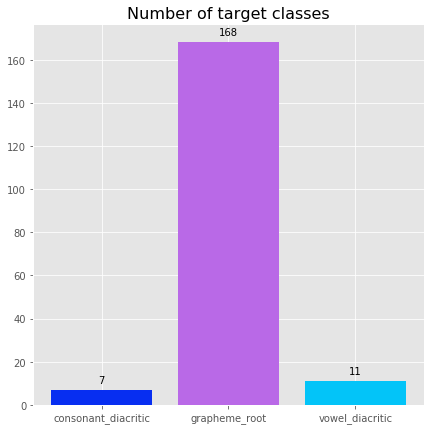

In [15]:
# plot bar chart with the number of classes to predict
fig, ax = plt.subplots(1,1,figsize=(7,7))
plt.bar(range(0,len(n_classes.label.values)), n_classes.label.values, color=['#072ef1', '#b969e7', '#03c4f8'])
plt.xticks(range(0,len(n_classes.label.values)), n_classes.index.values)
plt.title('Number of target classes', fontsize=16)
add_value_labels(ax)
plt.savefig('/home/sayan/Documents/Bengali_Grapheme/results/class_distribution.png')
plt.show()

In [28]:
HEIGHT = 236
WIDTH = 236

def get_top_n(df, field, n, top=True):
    top_graphemes = df.groupby([field]).size().reset_index(name='counts')['counts'].sort_values(ascending=not top)[:n]
    top_grapheme_roots = top_graphemes.index
    top_grapheme_counts = top_graphemes.values
    top_graphemes = class_map[class_map['component_type'] == field].reset_index().iloc[top_grapheme_roots]
    top_graphemes.drop(['component_type', 'label'], axis=1, inplace=True)
    top_graphemes.loc[:, 'count'] = top_grapheme_counts
    return top_graphemes

def image_from_char(char):
    image = Image.new('RGB', (WIDTH, HEIGHT))
    draw = ImageDraw.Draw(image)
    myfont = ImageFont.truetype('../data/kalpurush.ttf', 120)
    w, h = draw.textsize(char, font=myfont)
    draw.text(((WIDTH - w) / 2,(HEIGHT - h) / 3), char, font=myfont)

    return image


In [9]:
h = train_labels.groupby(['vowel_diacritic']).size().reset_index(name='counts')['counts'].sort_values()[:10]
class_map[class_map['component_type'] == 'vowel_diacritic'].reset_index().iloc[h.index]
class_map[class_map['component_type'] == 'vowel_diacritic'].reset_index().iloc[h.index]

,index,component_type,label,component
8,176,vowel_diacritic,8,ৈ
10,178,vowel_diacritic,10,ৌ
6,174,vowel_diacritic,6,ৃ
5,173,vowel_diacritic,5,ূ
9,177,vowel_diacritic,9,ো
3,171,vowel_diacritic,3,ী
4,172,vowel_diacritic,4,ু
2,170,vowel_diacritic,2,ি
7,175,vowel_diacritic,7,ে
1,169,vowel_diacritic,1,া


In [30]:
grapheme_root_img = train_labels.groupby(by=['grapheme_root']).count().reset_index()\
[['grapheme_root', 'image_id']].sort_values(by=['image_id'], ascending=False)

In [31]:
top_10_roots = get_top_n(train_labels, 'grapheme_root', 10)
bottom_10_roots = get_top_n(train_labels, 'grapheme_root', 10, False)
top_vowels = get_top_n(train_labels, 'vowel_diacritic', 11,True)
top_consonants = get_top_n(train_labels, 'consonant_diacritic', 7,True)

In [12]:
bottom_10_roots

,index,component,count
73,73,দ্ঘ,130
33,33,ঙ্ক্ত,136
102,102,প্স,141
158,158,স্স,143
45,45,জ্জ্ব,144
130,130,ল্ব,144
1,1,ঃ,145
12,12,ঔ,146
0,0,ং,147
63,63,ণ্ণ,149


### Top 10 Grapheme Roots

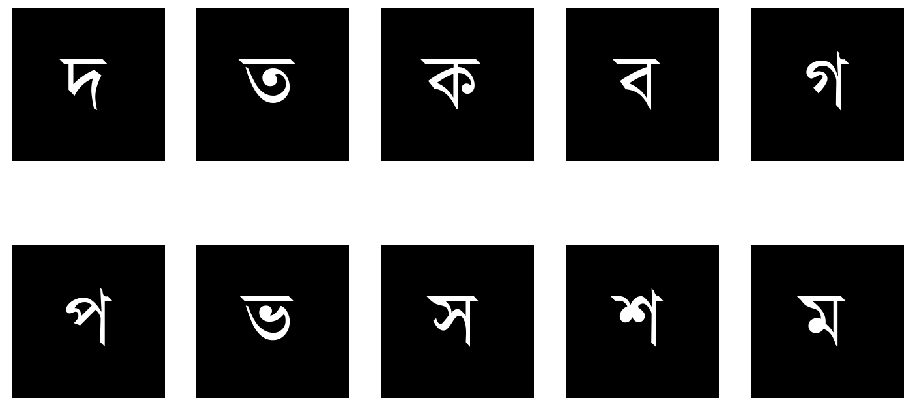

In [33]:
f, ax = plt.subplots(2, 5, figsize=(16, 8))
ax = ax.flatten()

for i in range(10):
    ax[i].get_xaxis().set_visible(False)
    ax[i].get_yaxis().set_visible(False)
    ax[i].imshow(image_from_char(top_10_roots['component'].iloc[i]), cmap='Greys')

plt.savefig('/home/sayan/Documents/Bengali_Grapheme/results/visual_top_10_grapheme.png')

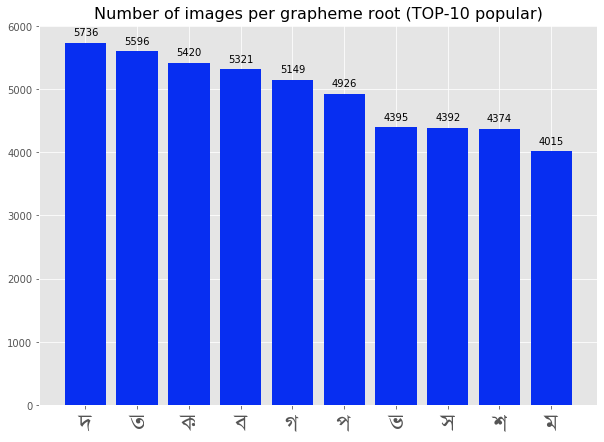

In [25]:
n_classes = 10
fig, ax = plt.subplots(1,1,figsize=(10,7))
plt.bar(range(0, n_classes), grapheme_root_img.image_id.values[:n_classes], color='#072ef1')
labels = [class_map[class_map.label == val].component.values[0] 
          for val in grapheme_root_img.grapheme_root.values[:n_classes]]

plt.xticks(range(0, n_classes), labels, fontproperties=prop, fontsize=24)
plt.title('Number of images per grapheme root (TOP-10 popular)', fontsize=16)
add_value_labels(ax)
plt.savefig('/home/sayan/Documents/Bengali_Grapheme/results/top_10_grapheme.png')
plt.show()

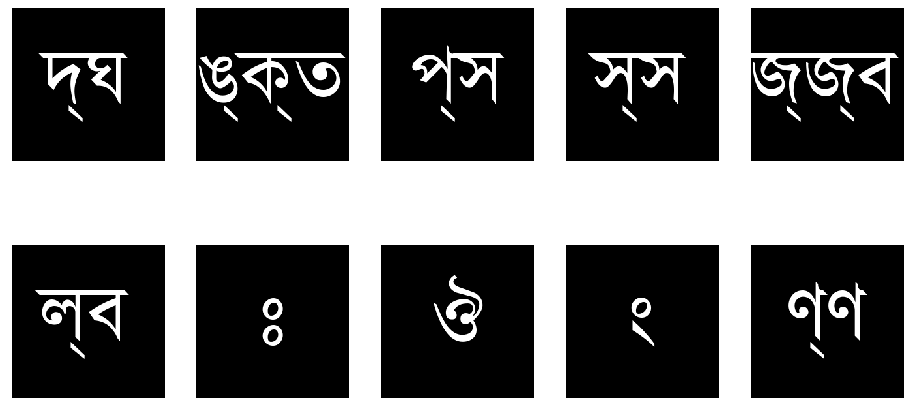

In [32]:
f, ax = plt.subplots(2, 5, figsize=(16, 8))
ax = ax.flatten()

for i in range(9,-1,-1):
    ax[i].get_xaxis().set_visible(False)
    ax[i].get_yaxis().set_visible(False)
    ax[i].imshow(image_from_char(bottom_10_roots['component'].iloc[i]), cmap='Greys')

plt.savefig('/home/sayan/Documents/Bengali_Grapheme/results/visual_bottom_10_grapheme.png')

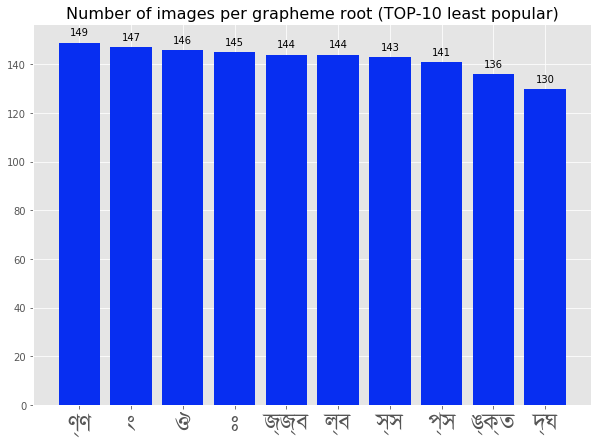

In [40]:
n_classes = 10
fig, ax = plt.subplots(1,1,figsize=(10,7))
plt.bar(range(0, n_classes), grapheme_root_img.image_id.values[-n_classes:], color='#072ef1')
labels = [class_map[class_map.label == val].component.values[0] for val in grapheme_root_img.grapheme_root.values[-n_classes:]]
prop = FontProperties()
prop.set_file('../data/kalpurush.ttf')
plt.xticks(range(0, n_classes), labels, fontproperties=prop, fontsize=24)
plt.title('Number of images per grapheme root (TOP-10 least popular)', fontsize=16)
add_value_labels(ax)
plt.savefig('/home/sayan/Documents/Bengali_Grapheme/results/bottom_10_grapheme.png')
plt.show()

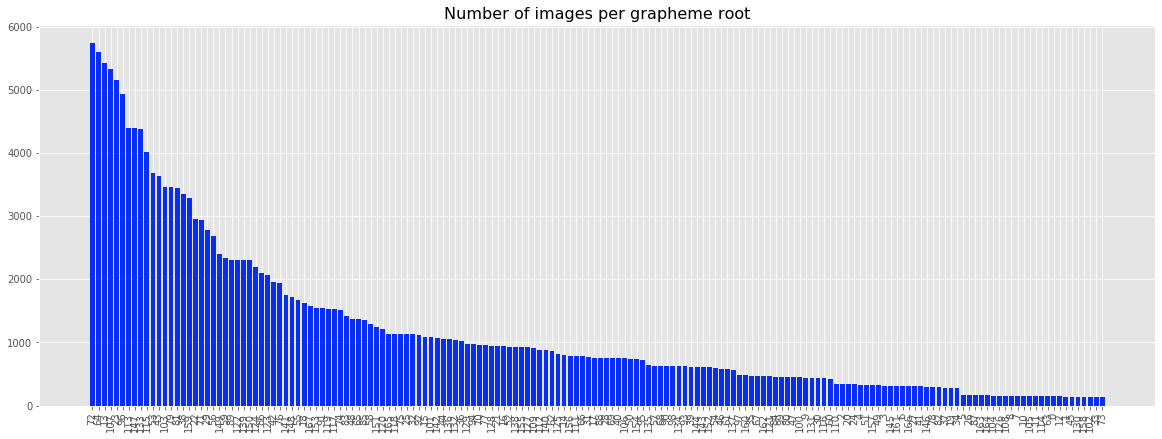

In [22]:
n_classes = len(grapheme_root_img)
fig, ax = plt.subplots(1,1,figsize=(20,7))
plt.bar(range(0, n_classes), grapheme_root_img.image_id.values, color='#072ef1')
plt.xticks(range(0, n_classes), grapheme_root_img.grapheme_root.values, rotation=90)
plt.title('Number of images per grapheme root', fontsize=16)
plt.savefig('/home/sayan/Documents/Bengali_Grapheme/results/grapheme_distribution_total.png')
plt.show()

## Top 10 Vowel Diacritics

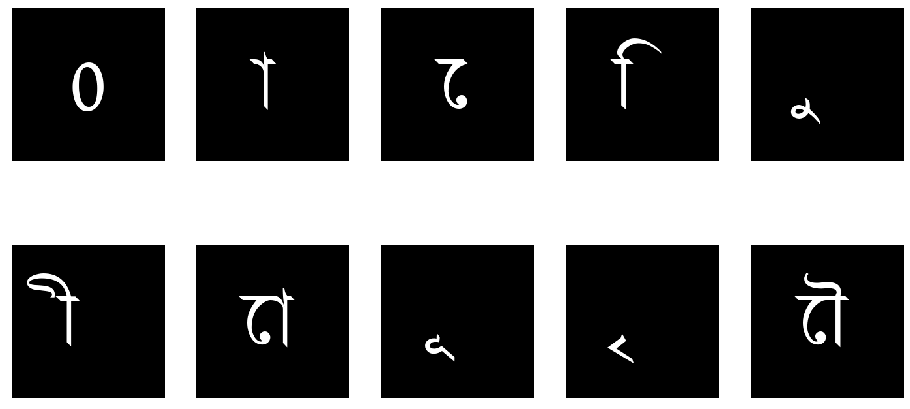

In [51]:
f, ax = plt.subplots(2, 5, figsize=(16, 8))
ax = ax.flatten()

for i in range(10):
    ax[i].get_xaxis().set_visible(False)
    ax[i].get_yaxis().set_visible(False)
    ax[i].imshow(image_from_char(top_vowels['component'].iloc[i]), cmap='Greys')

plt.savefig('/home/sayan/Documents/Bengali_Grapheme/results/visual_top_10_vowels.png')

In [36]:
vowel_diacritic_img = train_labels.groupby(by=['vowel_diacritic']).count().reset_index()\
[['vowel_diacritic', 'image_id']].sort_values(by=['image_id'], ascending=False)

grapheme_root_img = train_labels.groupby(by=['grapheme_root']).count().reset_index()\
[['grapheme_root', 'image_id']].sort_values(by=['image_id'], ascending=False)

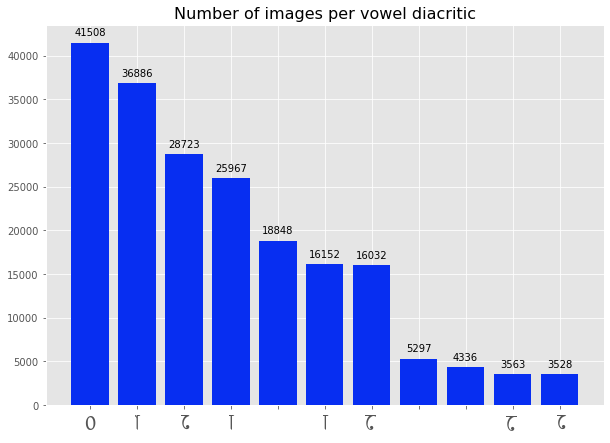

In [42]:
n_classes = len(vowel_diacritic_img)
fig, ax = plt.subplots(1,1,figsize=(10,7))
plt.bar(range(0, n_classes), vowel_diacritic_img.image_id.values, color='#072ef1')
#labels = top_vowels['component']
labels = [class_map[class_map.label == val].component.values[1] for val in vowel_diacritic_img.vowel_diacritic.values]
plt.xticks(range(0, n_classes), labels, fontproperties=prop, fontsize=24)
plt.title('Number of images per vowel diacritic', fontsize=16)
add_value_labels(ax)
plt.savefig('/home/sayan/Documents/Bengali_Grapheme/results/top_vowels.png')
plt.show()

## Top 10 Consonant diacritics

In [44]:
consonant_diacritic_img = train_labels.groupby(by=['consonant_diacritic']).count().reset_index()\
[['consonant_diacritic', 'image_id']].sort_values(by=['image_id'], ascending=False)

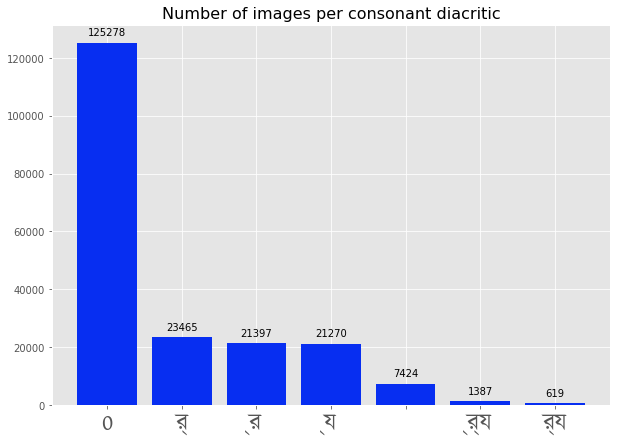

In [53]:
n_classes = len(consonant_diacritic_img)
fig, ax = plt.subplots(1,1,figsize=(10,7))
plt.bar(range(0, n_classes), consonant_diacritic_img.image_id.values, color='#072ef1')
labels = [class_map[class_map.label == val].component.values[2] for val in consonant_diacritic_img.consonant_diacritic.values]
plt.xticks(range(0, n_classes), labels, fontproperties=prop, fontsize=24)
plt.title('Number of images per consonant diacritic', fontsize=16)
add_value_labels(ax)
plt.savefig('/home/sayan/Documents/Bengali_Grapheme/results/top_consonants.png')
plt.show()

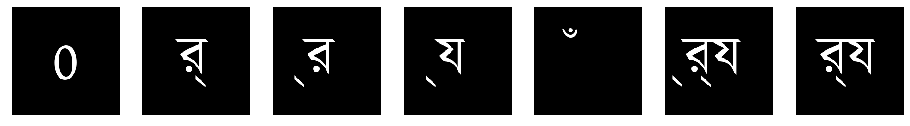

In [52]:
f, ax = plt.subplots(1, 7, figsize=(16, 4))
ax = ax.flatten()

for i in range(7):
    ax[i].get_xaxis().set_visible(False)
    ax[i].get_yaxis().set_visible(False)
    ax[i].imshow(image_from_char(top_consonants['component'].iloc[i]), cmap='Greys')

plt.savefig('/home/sayan/Documents/Bengali_Grapheme/results/visual_top_consonants.png')

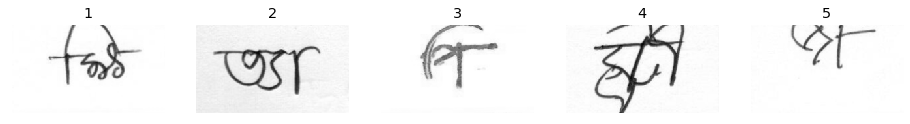

In [88]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5,figsize=(16, 4))

img1 = cv2.imread('/home/sayan/Documents/Bengali_Grapheme/results/Train_324.png')
img2 = cv2.imread('/home/sayan/Documents/Bengali_Grapheme/results/Train_611.png')
img3 = cv2.imread('/home/sayan/Documents/Bengali_Grapheme/results/Train_1838.png')
img4 = cv2.imread('/home/sayan/Documents/Bengali_Grapheme/results/Train_1180.png')
img5 = cv2.imread('/home/sayan/Documents/Bengali_Grapheme/results/Train_2940.png')

ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax1.title.set_text('1')
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax2.title.set_text('2')
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)
ax3.title.set_text('3')
ax4.get_xaxis().set_visible(False)
ax4.get_yaxis().set_visible(False)
ax4.title.set_text('4')
ax5.get_xaxis().set_visible(False)
ax5.get_yaxis().set_visible(False)
ax5.title.set_text('5')

ax1.imshow(img1)
ax2.imshow(img2)
ax3.imshow(img3)
ax4.imshow(img4)
ax5.imshow(img5)

plt.savefig('/home/sayan/Documents/Bengali_Grapheme/results/sample_raw.png')

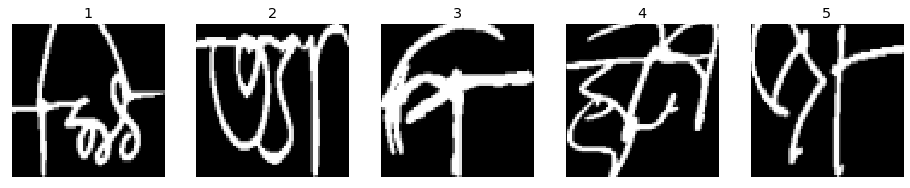

In [85]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5,figsize=(16, 4))

img1 = cv2.imread('/home/sayan/Documents/Bengali_Grapheme/results/Train_324_f.png')
img2 = cv2.imread('/home/sayan/Documents/Bengali_Grapheme/results/Train_611_f.png')
img3 = cv2.imread('/home/sayan/Documents/Bengali_Grapheme/results/Train_1838_f.png')
img4 = cv2.imread('/home/sayan/Documents/Bengali_Grapheme/results/Train_1180_f.png')
img5 = cv2.imread('/home/sayan/Documents/Bengali_Grapheme/results/Train_2940_f.png')

ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax1.title.set_text('1')
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax2.title.set_text('2')
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)
ax3.title.set_text('3')
ax4.get_xaxis().set_visible(False)
ax4.get_yaxis().set_visible(False)
ax4.title.set_text('4')
ax5.get_xaxis().set_visible(False)
ax5.get_yaxis().set_visible(False)
ax5.title.set_text('5')

ax1.imshow(img1)
ax2.imshow(img2)
ax3.imshow(img3)
ax4.imshow(img4)
ax5.imshow(img5)

plt.savefig('/home/sayan/Documents/Bengali_Grapheme/results/sample_processed.png')